In [38]:
import numpy as np
import pandas as pd
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

### Part 1: Motivation

### Part 2: DATA

In this part, we focus on evaluating effects of the policy change in Florida in 2010 has on opioid shipments.\
Data used in this opioid shipment analysis are from two data sources. One is the dataset of all prescription opioid drug shipments in the United States from 2006 to 2012, which was released by the Washington Post in mid-2019. And the other is the FIPS code data from http://www.census.gov/2010census/xls/fips_codes_website.xls. (We use FIPS code to uniquely identify each county.)

In this part, we only use the data of Florida and Ohio. The opioid drug shipments data of Florida contains 11,947,215 observations and Ohio has 7,342,016 observations. 

In order to reduce the data size, we only choose the features we want, including 'TRANSACTION_DATE', 'BUYER_COUNTY', 'CALC_BASE_WT_IN_GM', 'MME_Conversion_Factor', 'State' and 'FIPS'.\
After data cleaning and processing, we extract 'Year' from 'TRANSACTION_DATE' and compute 'Morphine_equ' by multiplying 'CALC_BASE_WT_IN_GM' and 'MME_Conversion_Factor'.Then we drop 'TRANSACTION_DATE', 'CALC_BASE_WT_IN_GM' and 'MME_Conversion_Factor'.

**Data Dictionary**

Year:  Year shipment occurred.\
FIPS: Code uniquely identifting each county.\
County: County name.\
Morphine_equ: The effective weight of the drug compared to morphine equivilent, in grams.\
State: FL or OH.

### Part 3: Exploratory Data Analysis

**3.1 Overall statistics**

In [126]:
FL_drug = pd.read_csv('FL_opioid_equ.csv')
OH_drug = pd.read_csv('OH_opioid_equ.csv')

In [127]:
#rename columns to make data more consistent
FL_drug.rename(columns = {'County_FIPS':'FIPS','BUYER_COUNTY':'County'},inplace = True)
OH_drug.rename(columns = {'County_FIPS':'FIPS','BUYER_COUNTY':'County'},inplace = True)

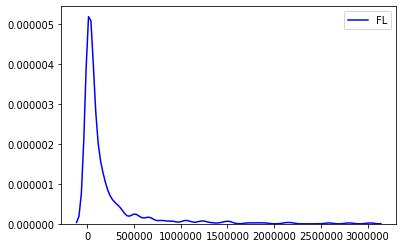

In [160]:
sns.kdeplot(FL_drug['Morphine_equ'],label = 'FL',color = 'b')
plt.show()

From the density plot, most of the Morphine_equ data lie between 0 and 250000. Let's look at the samples with Morphine_equ larger than 1500000.

In [162]:
FL_drug[FL_drug['Morphine_equ']>1500000]

,Year,FIPS,County,Morphine_equ,State
71,2007,12011,BROWARD,1.720337e+06,FL
137,2008,12011,BROWARD,2.180537e+06,FL
158,2008,12057,HILLSBOROUGH,1.507904e+06,FL
203,2009,12011,BROWARD,2.584508e+06,FL
225,2009,12057,HILLSBOROUGH,2.124149e+06,FL
247,2009,12099,PALM BEACH,1.813925e+06,FL
270,2010,12011,BROWARD,3.026737e+06,FL
292,2010,12057,HILLSBOROUGH,2.801561e+06,FL
314,2010,12099,PALM BEACH,1.897699e+06,FL
359,2011,12057,HILLSBOROUGH,1.533315e+06,FL


BROWARD, PALM BEACH and HILLSBOROUGH are the second, third and fourth most populous county in the state of Florida. It is reasonable that they have a large amount of Opioid shipments. However, it is interesting that the county with the most population in Florida, Miami-Dade, does not have the largest amount of opioid shipments.

In [163]:
FL_drug[FL_drug['FIPS']==12086]

,Year,FIPS,County,Morphine_equ,State
41,2006,12086,MIAMI-DADE,3.030397e+05,FL
107,2007,12086,MIAMI-DADE,3.734959e+05,FL
173,2008,12086,MIAMI-DADE,5.195368e+05,FL
240,2009,12086,MIAMI-DADE,8.019451e+05,FL
307,2010,12086,MIAMI-DADE,1.242761e+06,FL
374,2011,12086,MIAMI-DADE,1.070608e+06,FL
441,2012,12086,MIAMI-DADE,5.033139e+05,FL


From the article https://www.miamiherald.com/opinion/op-ed/article222917990.html, it seems that Miami-Dade has a unique benefit as home to the state’s first and only needle exchange program which helps it decrease the opioid consumption amount.\
Then we take a look at the distribution of Morphine_equ data of Ohio. It has the similar distribution as that of Florida, which is helpful when we compare these two states.

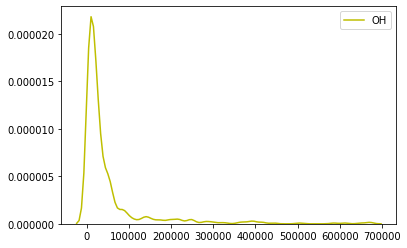

In [164]:
sns.kdeplot(OH_drug['Morphine_equ'],label = 'OH',color= 'y')
plt.show()

**3.2 Individual plot**

In this part, we randomly select 10 counties from FL and OH and plot their trends from 2006 to 2012.

In [133]:
FIPS_FL= np.array(FL_drug.FIPS.iloc[:])
FIPS_OH= np.array(OH_drug.FIPS.iloc[:])
rand_FL = np.random.randint(0,FIPS_FL.shape[0],10)
rand_OH = np.random.randint(0,FIPS_OH.shape[0],10)

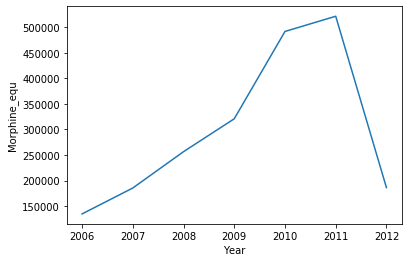

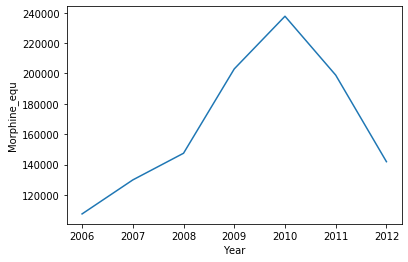

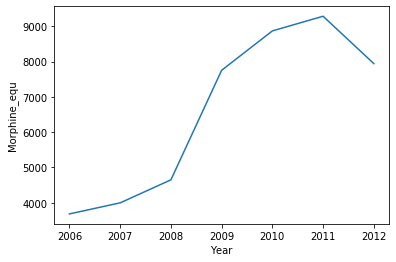

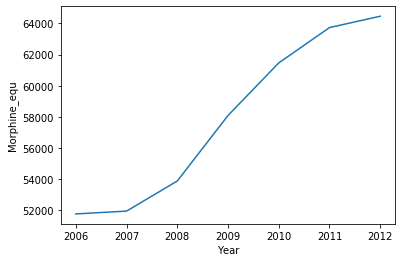

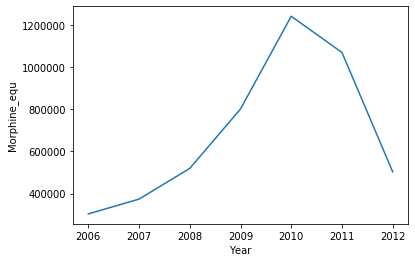

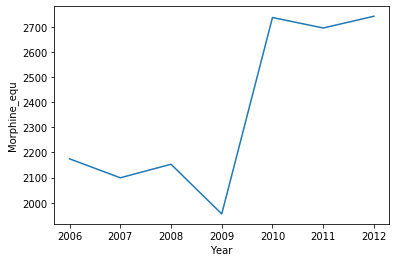

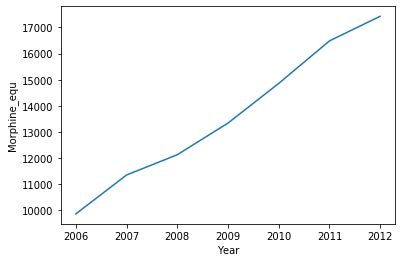

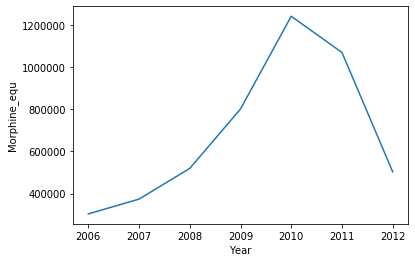

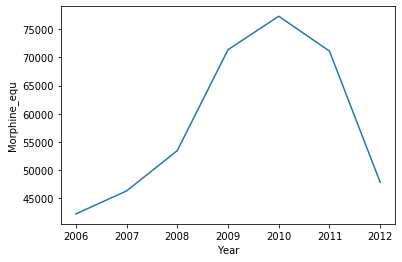

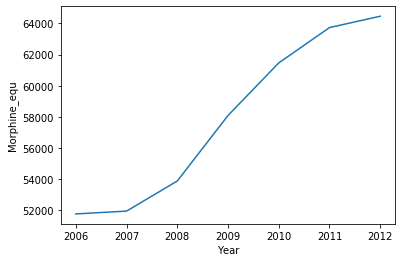

In [134]:
for i in range(10):
    ind = rand_FL[i]
    county =  FL_drug[FL_drug.FIPS==FIPS_FL[ind]]
    plt.figure()
    sns.lineplot(county.Year,county.Morphine_equ)

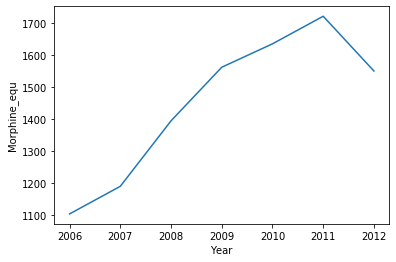

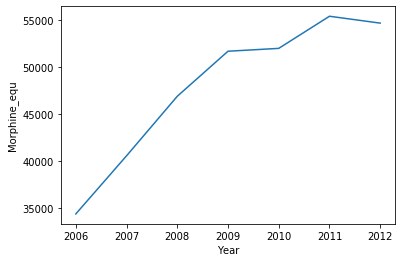

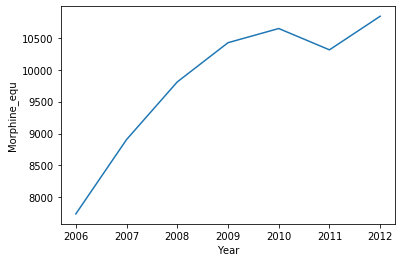

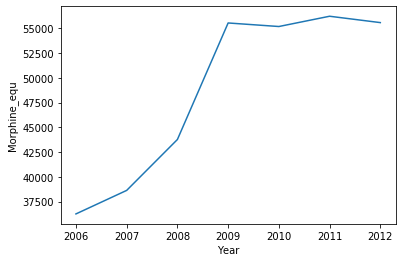

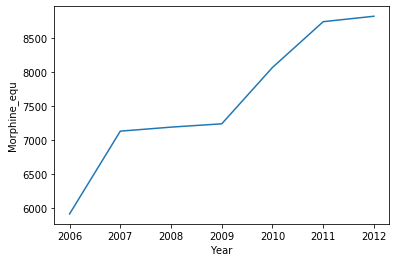

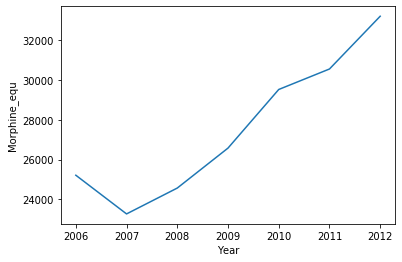

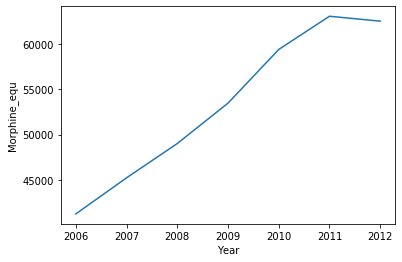

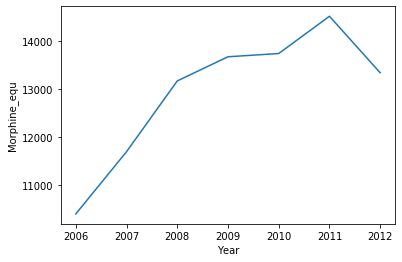

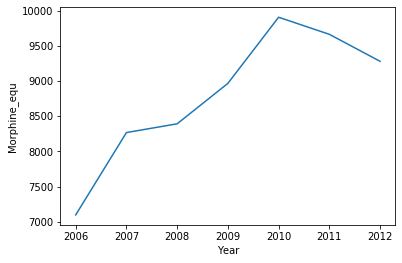

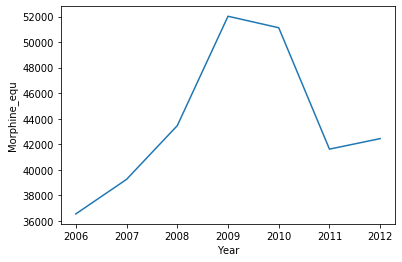

In [135]:
for i in range(10):
    ind = rand_OH[i]
    county =  OH_drug[OH_drug.FIPS==FIPS_OH[ind]]
    plt.figure()
    sns.lineplot(county.Year,county.Morphine_equ)

From the linecharts, there are clear turning points in 2010 in the FL plots but for the OH plots, the trend is unclear.

### Part 4: Pre-Post Analysis

In [171]:
#Groupby our data by year to see the overall change of the state
Mor_equ_FL = FL_drug.groupby('Year').mean()
Mor_equ_FL.reset_index(inplace = True)
#To make the change more clear, we use 'Years from Policy Change' instead of 'Year' to indicate time
Mor_equ_FL['Years from Policy Change'] = Mor_equ_FL.Year - 2010
Mor_equ_FL.head()

,Year,FIPS,Morphine_equ,Years from Policy Change
0,2006,12068.287879,114729.922401,-4
1,2007,12068.287879,140543.100758,-3
2,2008,12068.287879,182986.904227,-2
3,2009,12067.910448,230023.947179,-1
4,2010,12067.910448,298451.985515,0


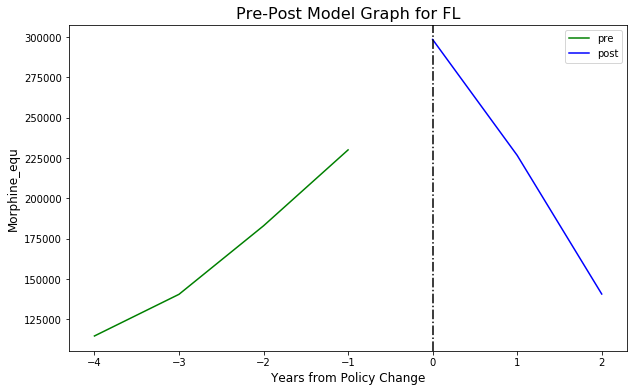

In [176]:
plt.figure(figsize=(10,6))
sns.lineplot(Mor_equ_FL[Mor_equ_FL['Year']<=2009]['Years from Policy Change'],Mor_equ_FL['Morphine_equ'],color="green",label = 'pre')
sns.lineplot(Mor_equ_FL[Mor_equ_FL['Year']>2009]['Years from Policy Change'],Mor_equ_FL['Morphine_equ'],color="blue",label = 'post')
plt.axvline(x=0,linestyle = '-.',color = 'black')
plt.xlabel("Years from Policy Change",fontsize = 12)
plt.ylabel("Morphine_equ",fontsize = 12)
plt.title("Pre-Post Model Graph for FL",fontsize = 16)
plt.show()

We can see the trend after 2010 is clearly different from that before 2010. If the policy is not effective, Florida would have been more likely to have the similar trend in 2011 as it in 2009. Therefore, the data shows a potentially successful policy change in Florida in 2010.

### Part 5: Difference in Difference Analysis

Before running the DID analysis, we plotted the opioid shipments data of GA,NC,AL,PA and OH, trying to find a state who has a parallel trend as that of FL. Unfortunately, we did not find such a state. Therefore, we choose a state, OH, whose trend are more parallel to that of FL than other states.

In [177]:
Mor_equ_OH = OH_drug.groupby('Year').mean()
Mor_equ_OH.reset_index(inplace = True)
Mor_equ_OH['Years from Policy Change'] = Mor_equ_OH.Year - 2010
Mor_equ_OH.head()

,Year,FIPS,Morphine_equ,Years from Policy Change
0,2006,39088,39010.549468,-4
1,2007,39088,43554.160491,-3
2,2008,39088,47845.490125,-2
3,2009,39088,53278.909200,-1
4,2010,39088,56680.547112,0


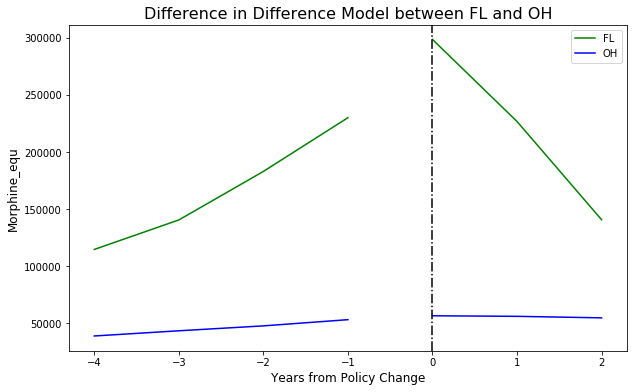

In [180]:
plt.figure(figsize=(10,6))
sns.lineplot(Mor_equ_FL[Mor_equ_FL['Year']<=2009]['Years from Policy Change'],Mor_equ_FL['Morphine_equ'],color="green",label = 'FL')
sns.lineplot(Mor_equ_FL[Mor_equ_FL['Year']>2009]['Years from Policy Change'],Mor_equ_FL['Morphine_equ'],color="green")
sns.lineplot(Mor_equ_OH[Mor_equ_OH['Year']<=2009]['Years from Policy Change'],Mor_equ_OH['Morphine_equ'],color="blue",label = 'OH')
sns.lineplot(Mor_equ_OH[Mor_equ_OH['Year']>2009]['Years from Policy Change'],Mor_equ_OH['Morphine_equ'],color="blue")
plt.axvline(x=0,linestyle = '-.',color = 'black')
plt.xlabel("Years from Policy Change",fontsize = 12)
plt.ylabel("Morphine_equ",fontsize = 12)
plt.title("Difference in Difference Model between FL and OH",fontsize = 16)
plt.show()

Clearly, we can see a deline trend in FL data after 2010 and the Morphine_equ data in OH did not change a lot. In the above plot, 2010 is set to be our policy change year but we can see an increase in the opioid amount from 2009 to 2010. To explain the strange trend, we looked at the original documents for this policy change in FL. Although this policy change took place in Feb 2010, it may took a longer time to actually take effects. Also, it followed a series changes which also have affected the opioid shipments.\
Therefore, we try 2011 as our policy change year.

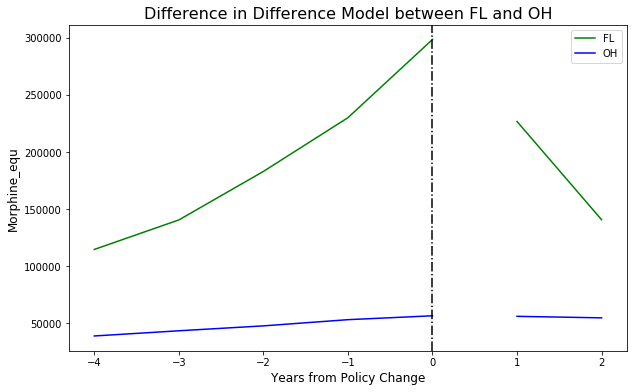

In [181]:
plt.figure(figsize=(10,6))
sns.lineplot(Mor_equ_FL[Mor_equ_FL['Year']<=2010]['Years from Policy Change'],Mor_equ_FL['Morphine_equ'],color="green",label = 'FL')
sns.lineplot(Mor_equ_FL[Mor_equ_FL['Year']>2010]['Years from Policy Change'],Mor_equ_FL['Morphine_equ'],color="green")
sns.lineplot(Mor_equ_OH[Mor_equ_OH['Year']<=2010]['Years from Policy Change'],Mor_equ_OH['Morphine_equ'],color="blue",label = 'OH')
sns.lineplot(Mor_equ_OH[Mor_equ_OH['Year']>2010]['Years from Policy Change'],Mor_equ_OH['Morphine_equ'],color="blue")
plt.axvline(x=0,linestyle = '-.',color = 'black')
plt.xlabel("Years from Policy Change",fontsize = 12)
plt.ylabel("Morphine_equ",fontsize = 12)
plt.title("Difference in Difference Model between FL and OH",fontsize = 16)
plt.show()

In this case, $D(policy) = {[D(FL_{post})-D(FL_{pre})] - [D(OH_{post})-D(OH_{pre})]}$ is negative.\
The policy change can help FL reduce opioid shipments.

### Part 6: Regression (results not so good...)

In [195]:
all_drug = pd.concat([FL_drug,OH_drug],ignore_index = True)
#Set dummy variable to separate treatment state and control state
all_drug['D_tr'] = [1 if x == 'FL' else 0 for x in all_drug.State]
#Set dummy variable to separate post and pre
all_drug['D_post'] = [1 if x >2010 else 0 for x in all_drug.Year]

In [196]:
all_drug.sample(10)

,Year,FIPS,County,Morphine_equ,State,D_tr,D_post
366,2011,12071,LEE,587055.726865,FL,1,1
167,2008,12075,LEVY,28379.512613,FL,1,0
317,2010,12105,POLK,285711.952307,FL,1,0
652,2008,39021,CHAMPAIGN,9809.713176,OH,0,0
427,2012,12059,HOLMES,5462.597160,FL,1,1
110,2007,12091,OKALOOSA,51948.686904,FL,1,0
637,2007,39167,WASHINGTON,17722.202731,OH,0,0
124,2007,12119,SUMTER,16784.182853,FL,1,0
964,2011,39117,MORROW,7636.801999,OH,0,1
6,2006,12013,CALHOUN,1851.905823,FL,1,0


In [197]:
#set interaction term
all_drug['post_policy'] = all_drug['D_post']*all_drug['D_tr']

In [198]:
all_drug.sample(10)

,Year,FIPS,County,Morphine_equ,State,D_tr,D_post,post_policy
75,2007,12019,CLAY,85815.940695,FL,1,0,0
606,2007,39105,MEIGS,15321.773900,OH,0,0,0
311,2010,12093,OKEECHOBEE,55324.330290,FL,1,0,0
68,2007,12005,BAY,61255.857999,FL,1,0,0
325,2010,12121,SUWANNEE,13182.171206,FL,1,0,0
1019,2012,39051,FULTON,10723.574786,OH,0,1,0
476,2006,39021,CHAMPAIGN,7738.052919,OH,0,0,0
889,2010,39143,SANDUSKY,18039.241730,OH,0,0,0
669,2008,39055,GEAUGA,16845.811834,OH,0,0,0
756,2009,39053,GALLIA,26521.133608,OH,0,0,0


In [199]:
mod = smf.ols('Morphine_equ~D_post+D_tr+post_policy',data = all_drug)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Morphine_equ   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     25.82
Date:                Mon, 11 Nov 2019   Prob (F-statistic):           3.90e-16
Time:                        16:11:48   Log-Likelihood:                -15027.
No. Observations:                1082   AIC:                         3.006e+04
Df Residuals:                    1078   BIC:                         3.008e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.807e+04   1.24e+04      3.868      